<a href="https://colab.research.google.com/github/JankaUhrinova/Assessing-Unsupervised-Pretraining-for-improving-prediction-in-Digital-Pathology/blob/main/pytorch_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import libraries

In [2]:
import torch
import numpy as np
from torchvision.transforms import Lambda, ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

load data 

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



visualise data

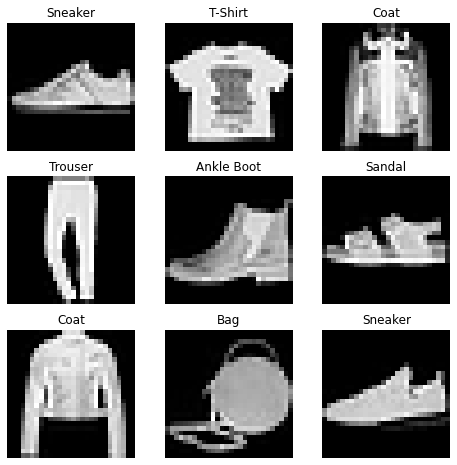

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


customisig dataset

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Dataloader wraps the batch of data from the dataset for easy access (in this case, we have 64 objects from both datasets). Shuffle makes sure the batch data were chosen randomly.

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

During iteration one batch of 64 samples is used and when all samples have been loaded, the dataset is shuffled

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


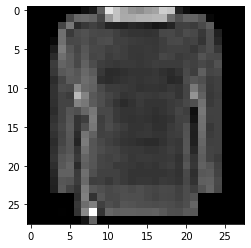

Label: 2


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

transfom -> modifies the data using transformation logic that is sent to it (as a parameter) to modify the data into the form that is more suitable for our training
target_transform -> the same but for labels


lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)

returns the one-hot tensor where the possition corresponding to the label has value of 1 and the other values are 0s.

ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]


In [8]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


in __init__ we initialize the neural network with all the layers (number of incoming and outcoming nodes) 
in forward function, you can implement operations on the input data

- We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

- The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

- nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

creating an actual instance of the nn and passing it to a variable -> model

In [11]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


X -> is a randomly generated data set as an example that represents one "picture"
we call the model on it
dim = 0 -> each output of 10 raw predicted values for each class
dim = 1 -> corresponding to the individual values of each output 

The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

In [12]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")


Predicted class: tensor([3])


Using parameters() or named_parameters() shows weights and biases of each layer of nn.Module 

In [13]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0122,  0.0309, -0.0219,  ..., -0.0335, -0.0169,  0.0184],
        [-0.0051, -0.0164, -0.0175,  ..., -0.0011, -0.0250,  0.0131]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0120, -0.0143], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0340, -0.0133, -0.0137,  ..., -0.0438,  0.0224, -0.0037],
        [ 0.0166,  0.0433,  0.0382,  ...,  0.0006, -0.0170,  0.0192]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

torch.autograd automatically calculates the gradient that is then used for back propagation.

x.requires_grad_(True) has to be set for the input tensor for autograd to work

In [14]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

o optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters
under some fixed values of x and y. To compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad

In [15]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2973, 0.3282, 0.0361],
        [0.2973, 0.3282, 0.0361],
        [0.2973, 0.3282, 0.0361],
        [0.2973, 0.3282, 0.0361],
        [0.2973, 0.3282, 0.0361]])
tensor([0.2973, 0.3282, 0.0361])
